# Activity 1b - Projective Transformation

Your name: Said Abdalrahim

Your ID number: 24177075

Now, we are still in the space of 2D image transforms. However, there are some transforms that we cannot complete with a 2x2 matrix. We need to move into the homogeneous (or projective) domain. A simple example of this is translation. Let's investigate.

 * You must not use external libraries other than numpy for calculations and pyplot for displaying the images. We use OpenCV just to read the images - but this must not be used elsewhere. All the libraries are imported in the first cell.

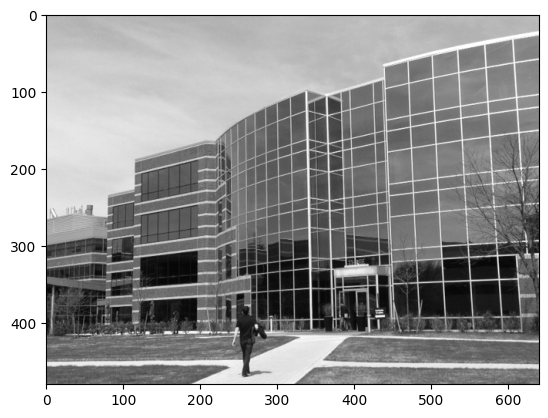

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('building1.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap='gray')

## Translation by adding vectors

Let's start with the basics of translating the image. We can do this by adding a translation vector to each coordinate (or the inverse if we are back-mapping, which is simply the subtraction of the vector. Look to Lecture 1.5 for the details on this. But the translation by vector addition is given by
$$
\begin{bmatrix} x' \\ y' \end{bmatrix} =
\begin{bmatrix} x \\ y \end{bmatrix} +
\begin{bmatrix} a \\ b \end{bmatrix}
$$
and the inverse is
$$
\begin{bmatrix} x \\ y \end{bmatrix} =
\begin{bmatrix} x' \\ y' \end{bmatrix} -
\begin{bmatrix} a \\ b \end{bmatrix}
$$
When these are applied to every pixel in the image, we get a translated image.

<font color='blue'>
    
##### Task:

In the last Python Notebook, you implemented a back-mapping method for transforming the image, based on defining a transform $\mathbf{T}$ and then using the inverse $\mathbf{T}^{-1}$.
    
Implement a back-mapping method for translation by vector addition. However, instead of multiplying by the inverse transform $\mathbf{T}^{-1}$, do this by subtracting the translation vector.
    
Much of the code will be similar to the code you created in the last workbook. Feel free to copy it over.
    
Be sure to check that the pixel locations are valid, and display your translated image.

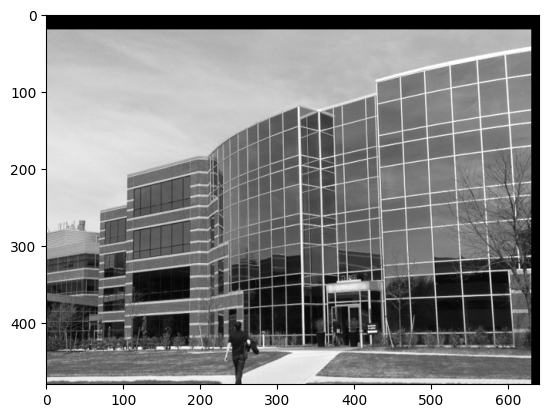

In [2]:

def translate_simple(translate_x, translate_y, shape):
    """
    Translates an image by the given x and y offsets.
    Parameters:
    translate_x (int): The translation offset in the x direction.
    translate_y (int): The translation offset in the y direction.
    shape (tuple): The shape of the output image (height, width).
    Returns:
    numpy.ndarray: The translated image with the specified shape.
    """
    T = np.array([translate_x, translate_y])  
    img_new = np.zeros(shape)

    for y in range(img_new.shape[0]):  
        for x in range(img_new.shape[1]): 
            pt_new = np.array([x,y])
            pt = pt_new - np.array(-T)
            if (0 <= pt[0] < img.shape[1]) and (0 <= pt[1] < img.shape[0]):
                img_new[pt[1], pt[0]] = img[y, x]

    return img_new


img_new = translate_simple(-10, 20, img.shape)

# Display the new image
plt.imshow(img_new,cmap='gray')
plt.show()

## Translation using homogeneous transform

Adding and subtracting vectors is fine, but we like to represent it as a matrix, which brings it into the linear algebra fold, and we can use the whole suite of linear algebra tools that come with that, such as Eigen everything, least squares, singular value decompositions, and so on. This all assumes that we can represent the transformation as a matrix.

But we know, we can't do this using 2x2 matrices. We must move to 3x3 homogeneous transforms.

In this case, we can represent a translation as
$$
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} =
\begin{bmatrix}
1 & 0 & a \\
0 & 1 & b \\
0 & 0 & 1
\end{bmatrix}  
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
$$
where $(a,b)^\top$ is the translation vector.

<font color='blue'>
    
##### Task:
    
Again using back-mapping, implement a homogeneous transform (represented as a 3x3 matrix) version of the translation.
    
Use the same translation as you used in the code above, and see that the result is the same.
    
A couple of hints:
 * With back-mapping, we need to use the inverse transform. This is fine with homogeneous transforms, the inversion process (`np.linalg.inv`) works with homogeneous transforms.
 * When you are reading pixel locations as $(x,y)$, to apply the homogeneous transform, you need to convert them to the canonical homogeneous form $(x,y,1)$. You can then multiply this homgeneous coordinate with the homogeneous transform
 * In this case, you don't need to worry about dehomogenisation of the result. You can just take the first two elements of the resulting vector as your transformed coordinate (i.e., just drop the last element of the new coordinate).

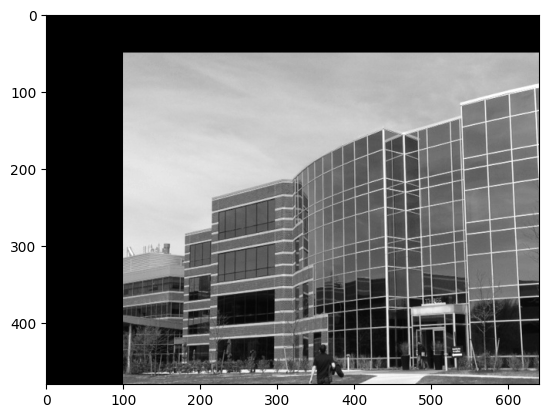

In [3]:
def back_map(T, shape):
    """
    Applies a projective transformation to an image and maps the pixels back to the original image.
    Parameters:
    T (numpy.ndarray): A 3x3 transformation matrix.
    shape (tuple): The shape of the original image (height, width).
    Returns:
    numpy.ndarray: The transformed image with the same shape as the original.
    """
    # Create a new empty image of the size of the original
    img_new = np.zeros(shape)

    for y in range(img_new.shape[0]):  # iterate each row in the image
        for x in range(img_new.shape[1]):  # iterate each column
            
            pt_new = np.array([x,y, 1])
            
            pt = T @ pt_new
            pt = pt.astype(int)
            # check that the resulting point is within the image bounds
            pt = np.rint(pt).astype(int)
            if (0 <= pt[0] < img.shape[1]) and (0 <= pt[1] < img.shape[0]):
                img_new[y][x] = img[pt[1]][pt[0]]
    
    return img_new

def translate(translate_x, translate_y):
    """
    Applies a translation transformation to an image.

    Parameters:
    translate_x (float): The translation distance along the x-axis.
    translate_y (float): The translation distance along the y-axis.

    Returns:
    numpy.ndarray: The translation transform matrix.
    """
    T = np.array([[1, 0, translate_x],[0, 1, translate_y],[0, 0, 1]])
    return T


img_new = back_map(np.linalg.inv(translate(100, 50)), img.shape)

# Display the new image
plt.imshow(img_new,cmap='gray')
plt.show()

<font color='blue'>

##### Question: Above I say that, in this particular case, you don't need to worry about dehomogenisation. Dehomogenisation usually involves dividing the vector by the last element, and then dropping the last element, i.e., $(x, y, w) \rightarrow (x/w, y/w)$. Specifically in the case above, why is this not needed?

in this case we don't need to do this because we are doing operations on the projective plane, this means that our w element stays = 1, we'd need to dehomogenise in case we perform operations that move us out of the projective plane, such as rotation on the z axis.

## Combine rotation and translation in one homogeneous transform

Now let's make a slightly more complex homogeneous transformation, combining rotation and translation. A homogeneous rotation is given by
$$
\textbf{R} = \begin{bmatrix}
\cos(\theta) & -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

We combine the translation and rotation through matrix multiplication:
$$
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} =
\begin{bmatrix}
1 & 0 & t_x \\
0 & 1 & t_y \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
$$

(Note that we have changed notation slightly to use $(t_x, t_y)$ as the translation vector).

<font color='blue'>
    
##### Task:
    
Using back-mapping, implement a homogeneous transform that incorporates translation and rotation.
    
Do this by defining the homogenous translation and rotation matrices separately, and then combining into one transformation by multiplying the two matrices together.


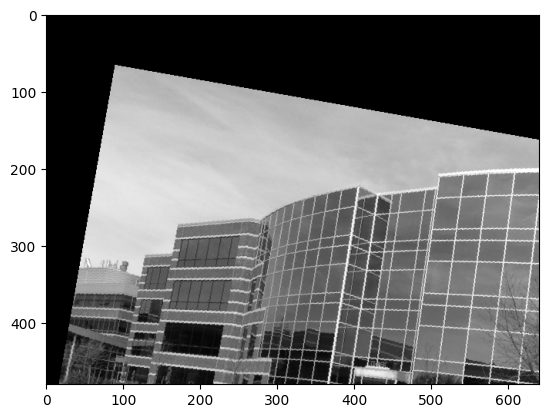

In [4]:
def translate_rotate(translate_x, translate_y, deg, shape):
    """
    Applies a translation and rotation transformation to an image.

    Parameters:
    translate_x (float): The translation distance along the x-axis.
    translate_y (float): The translation distance along the y-axis.
    deg (float): The rotation angle in degrees.
    shape (tuple): The shape of the image to be transformed.

    Returns:
    numpy.ndarray: The transformed image after applying the translation and rotation.
    """
    T_translate = np.array([[1, 0, translate_x],[0, 1, translate_y],[0, 0, 1]])
    T_rotate = np.array([[np.cos(np.radians(deg)), -np.sin(np.radians(deg)), 0],[np.sin(np.radians(deg)), np.cos(np.radians(deg)), 0],[0, 0, 1]])
    T = T_rotate @ T_translate
    return back_map(np.linalg.inv(T), shape)


img_new = translate_rotate(100, 50, 10, img.shape)

# Display the new image
plt.imshow(img_new,cmap='gray')
plt.show()

## Add in a scaling

We can incorporate scaling as well, as discussed in Lecture 1.6

$$
\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} =
\begin{bmatrix}
1 & 0 & t_x \\
0 & 1 & t_y \\
0 & 0 & 1
\end{bmatrix}  
\begin{bmatrix}
s_x & 0 & 0 \\
0 & s_x & 0 \\
0 & 0 & 1
\end{bmatrix}  
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
$$

<font color='blue'>

##### Task:
    
Using back-mapping, implement a homogeneous transform that incorporates translation, scaling and rotation, per the equation above.
    
Do this by defining the homogenous translation, scaling, and rotation matrices separately, and then combining into one transformation by multiplying the two matrices together.

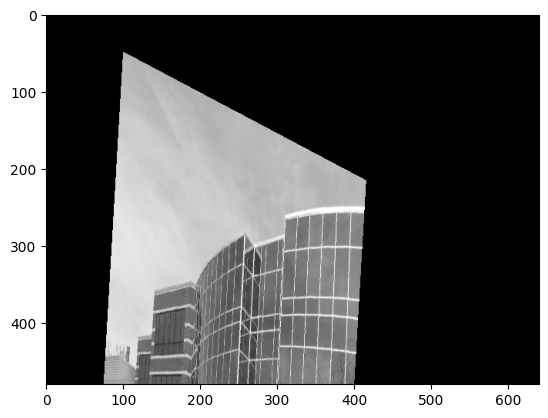

In [5]:
def translate_rotate(translate_x, translate_y, deg, scale_x, scale_y, shape):
    """
    Applies translation, rotation, and scaling transformations to a given shape.

    Parameters:
    translate_x (float): The translation distance along the x-axis.
    translate_y (float): The translation distance along the y-axis.
    deg (float): The rotation angle in degrees.
    scale_x (float): The scaling factor along the x-axis.
    scale_y (float): The scaling factor along the y-axis.
    shape (numpy.ndarray): The shape to be transformed.

    Returns:
    numpy.ndarray: The transformed shape after applying the inverse of the combined transformation matrix.
    """
    T_translate = np.array([[1, 0, translate_x],[0, 1, translate_y],[0, 0, 1]])
    # use np.radians to make it easier to understand
    T_rotate = np.array([[np.cos(np.radians(deg)), -np.sin(np.radians(deg)), 0],[np.sin(np.radians(deg)), np.cos(np.radians(deg)), 0],[0, 0, 1]])
    T_scale = np.array([[scale_x, 0, 0],[0, scale_y, 0],[0, 0, 1]])
    T = T_translate @ T_scale @ T_rotate
    return back_map(np.linalg.inv(T), shape)


img_new = translate_rotate(100, 50, 10, 0.5, 1.5, img.shape)

# Display the new image
plt.imshow(img_new,cmap='gray')
plt.show()

## Rotate the image about its centre point

Currently, all rotation is about the origin, i.e., the top left corner of the image. What if we want to rotate about a different point? This is just a combination of three different homogeneous transforms. Have a look at Lecture 1.6 again.

<font color='blue'>
    
##### Task:

Implement a rotation about the centre of the image, by defining three independent homogeneous matrices and combining them into one matrix.

to rotate the image about its centre point we first translate it to that point, perform the rotation, and translate it back, so we need three transformations in total

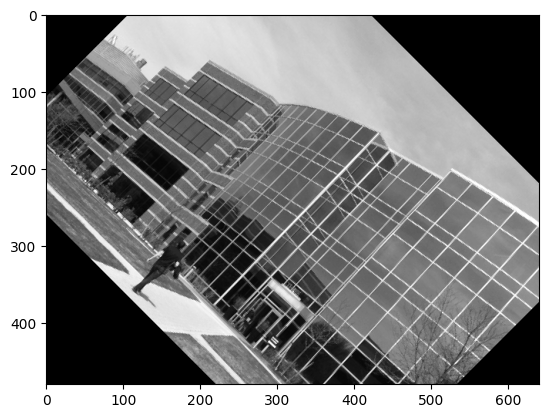

In [17]:
def rotate_around_centre(deg, shape):
    """
    Rotates an image around its center by a given degree.

    Parameters:
    deg (float): The angle in degrees by which to rotate the image.
    shape (tuple): The shape of the image as a tuple (height, width).

    Returns:
    numpy.ndarray: The transformed image after rotation.
    """
    rad = np.radians(deg)
    centre_points = np.array([shape[0]//2, shape[1]//2])
    T_translate = translate(-centre_points[1], -centre_points[0])
    T_rotate = np.array([[np.cos(rad), -np.sin(rad), 0],[np.sin(rad), np.cos(rad), 0],[0, 0, 1]])
    T_translate_back = translate(centre_points[1], centre_points[0])
    T = T_translate_back @ T_rotate @ T_translate
    return back_map(np.linalg.inv(T), shape)


img_new = rotate_around_centre(45, img.shape)

# Display the new image
plt.imshow(img_new,cmap='gray')
plt.show()

## Perspective

Up until now, even though we have been using 3 dimensional matrices and vectors, we haven't really got a feel for the "third dimension". It's still all been two dimensional, sliding, rotating, or squishing the image on the plane. We have used homogeneous transformations as a handy way to represent this, but we understood that we could do this using 2D matrices and vector addition.

Now let's look at adding in perspective, which starts to give us the 3D feel. Of course, we are still only transforming the image on the image plane. Technically we are still in the 2D space. But it gives the feel for the extra dimension.

In the images above, we know what the $x$- and $y$-axes are (left-right and up-down). We can think about the $z$-axis as pointing "out of" the image, and so the rotation we discuss above is a rotation "about the $z$-axis".

What about rotating about the other axes? The image below (from Lecture 1.7) shows what a rotation about the $y$-axis looks like.


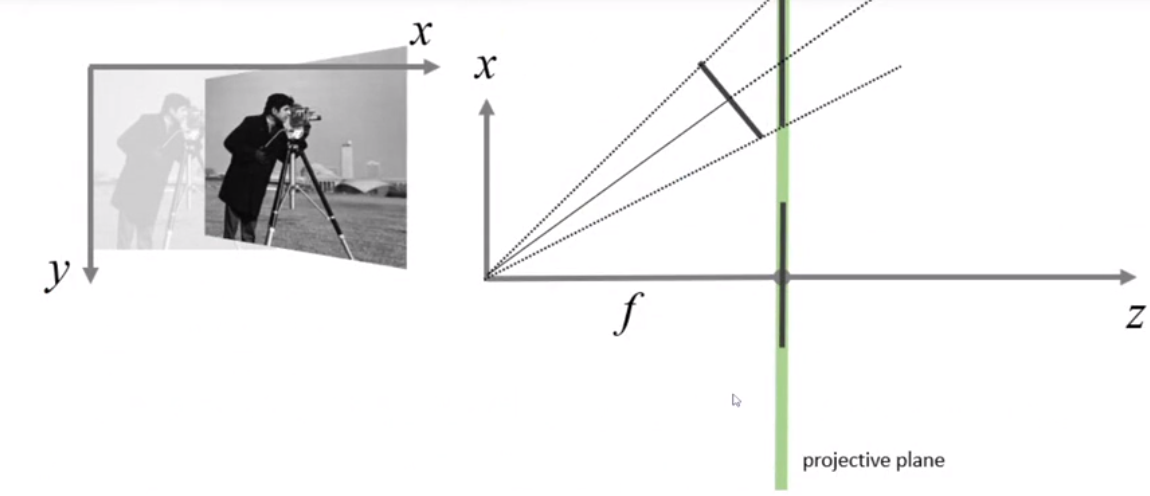


What does the rotation about the $y$-axis look like in matrix form? Simple, it's the same as the 3D rotation about.
$$
\textbf{R}_y =
\begin{bmatrix}
\cos(\theta) & 0 & -\sin(\theta) \\
0 & 1 & 0 \\
\sin(\theta) & 0 & \cos(\theta)
\end{bmatrix}
$$
And equivalently, we can do a rotation about the $x$-axis:
$$
\textbf{R}_x =
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos(\theta) & -\sin(\theta) \\
0 & \sin(\theta) & \cos(\theta)
\end{bmatrix}
$$

Now there is a gotcha. We don't get this pseudo perspective transformation for free. We do need to know some extra information. In the next lectures we will go into more detail on camera models and normalising image points. But for the moment, we have just need to know that when we get our $(x, y)$ coordinates before applying the transform, we need to divide them by the camera focal length $f$ before we can apply the rotation.

That is, the above two rotations only work in normalised image coordinates (that is what this is called).

The steps are (for back-mapping):
1. Get the coordinate $(x', y')$ from the output image
1. Divide by the focal length and convert to homogeneous $f$, i.e., $(x'/f, y'/f, 1)$ - this is our normalised coordinate
1. Apply the inverse transform, i.e. $(x, y) = \textbf{T}^{-1}(x'/f, y'/f, 1)^\top$
1. Get the final pixel value in the original image by muliplying by $f$, i.e., $(fx, fy)$

In the case of the image we have been using, $f=900$.

Does this seem out of the blue? Maybe you are asking, what is this "focal length"? And wtf is a "normalised" image coordinate? No problem, and don't worry. We will cover them in future lessons in quite some detail (now aren't you upset you asked?). Suffice to say at the moment that $f$ is the distance from the projection centre to the image plane as shown above (what's an image plane, I hear you ask?).

<font color='blue'>
    
##### Task:
    
Implement the following perspective rotations:
1. Rotate about the $y$-axis
1. In a second cell, rotate about the $x$-axis
1. In a third cell, rotate about both the $x$- and $y$-axes - we know now how to combine transformations now, yes?

Notes:
 * Remember, divide the coordinates by $f$ (in this case, $f=900$) before applying the transform
 * And then multiply by $f$ after you apply the transformation
 * In previous exercises, we didn't need to worry about dehomogenising our vectors, as the $w$-element was always $1$ (and dividing by $1$ does nothing). But now, this is not the case! So, after transforming the vectors, we need to dehomogenise by dividing by the third element. That is $(x, y, w) \rightarrow (x/w, y/w)$. Be careful to check that the $w$ element is not zero.
    

note that the plotted values are similar to other students for easy comparison.

/tmp/ipykernel_4573/556189888.py:26: RuntimeWarning: invalid value encountered in cast
  pt = np.rint(pt).astype(int)


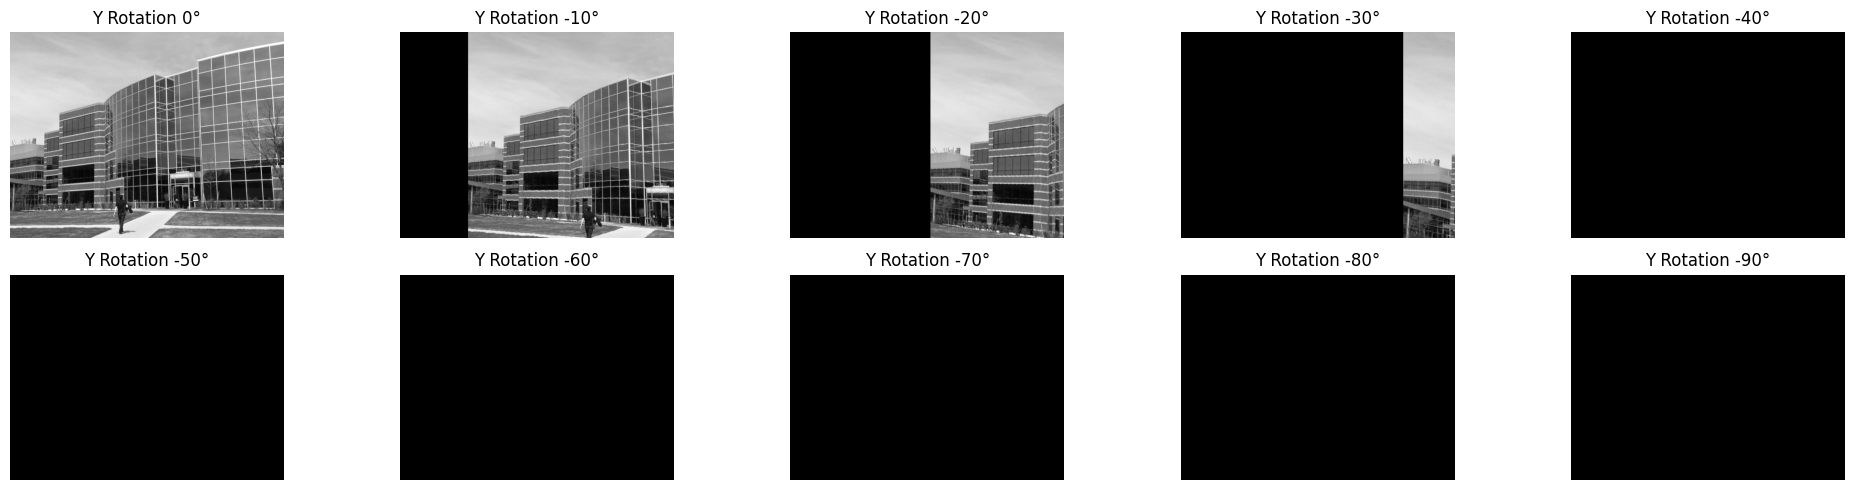

In [20]:
FOCAL_LENGTH = 900

def prespective_map(T, shape):
    """
    Applies a perspective transformation to an image.
    Parameters:
    T (numpy.ndarray): A 3x3 transformation matrix.
    shape (tuple): The shape of the original image (height, width).
    Returns:
    numpy.ndarray: The transformed image with the same shape as the original.
    """
    # Create a new empty image of the size of the original
    img_new = np.zeros(shape)

    for y in range(img_new.shape[0]):  # iterate each row in the image
        for x in range(img_new.shape[1]):  # iterate each column
            
            pt_new = np.array([x/FOCAL_LENGTH, y/FOCAL_LENGTH, 1])
            
            pt = T @ pt_new
            
            pt = pt / pt[2]

            pt = pt * FOCAL_LENGTH
            # check that the resulting point is within the image bounds
            pt = np.rint(pt).astype(int)
            if (0 <= pt[0] < img.shape[1]) and (0 <= pt[1] < img.shape[0]):
                img_new[y][x] = img[pt[1]][pt[0]]
    
    return img_new

def rotate_axis(deg, axis):
    """
    Rotates a 3D shape around the specified axis by a given degree.

    Parameters:
    deg (float): The angle in degrees by which to rotate the shape.
    axis (str): The axis around which to rotate the shape ('x', 'y', or 'z').

    Returns:
    numpy.ndarray: The inverted transformation matrix for the rotation around the specified axis.
    """
    if axis == 'x':
        T = np.array([[1, 0, 0], [0, np.cos(np.radians(deg)), -np.sin(np.radians(deg))], [0, np.sin(np.radians(deg)), np.cos(np.radians(deg))]])
    elif axis == 'y':
        T = np.array([[np.cos(np.radians(deg)), 0, -np.sin(np.radians(deg))], [0, 1, 0], [np.sin(np.radians(deg)), 0, np.cos(np.radians(deg))]])
    elif axis == 'z':
        T = np.array([[np.cos(np.radians(deg)), -np.sin(np.radians(deg)), 0], [np.sin(np.radians(deg)), np.cos(np.radians(deg)), 0], [0, 0, 1]])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'")
    return np.linalg.inv(T)

# plotting code (inspired by other students)
fig, axes = plt.subplots(2, 5, figsize=(20, 5))
axes = axes.ravel()

for idx, i in enumerate(range(0, -100, -10)):
    img_new = prespective_map(rotate_axis(i, 'y'), img.shape)
    axes[idx].imshow(img_new, cmap='gray')
    axes[idx].set_title(f'Y Rotation {i}°')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()



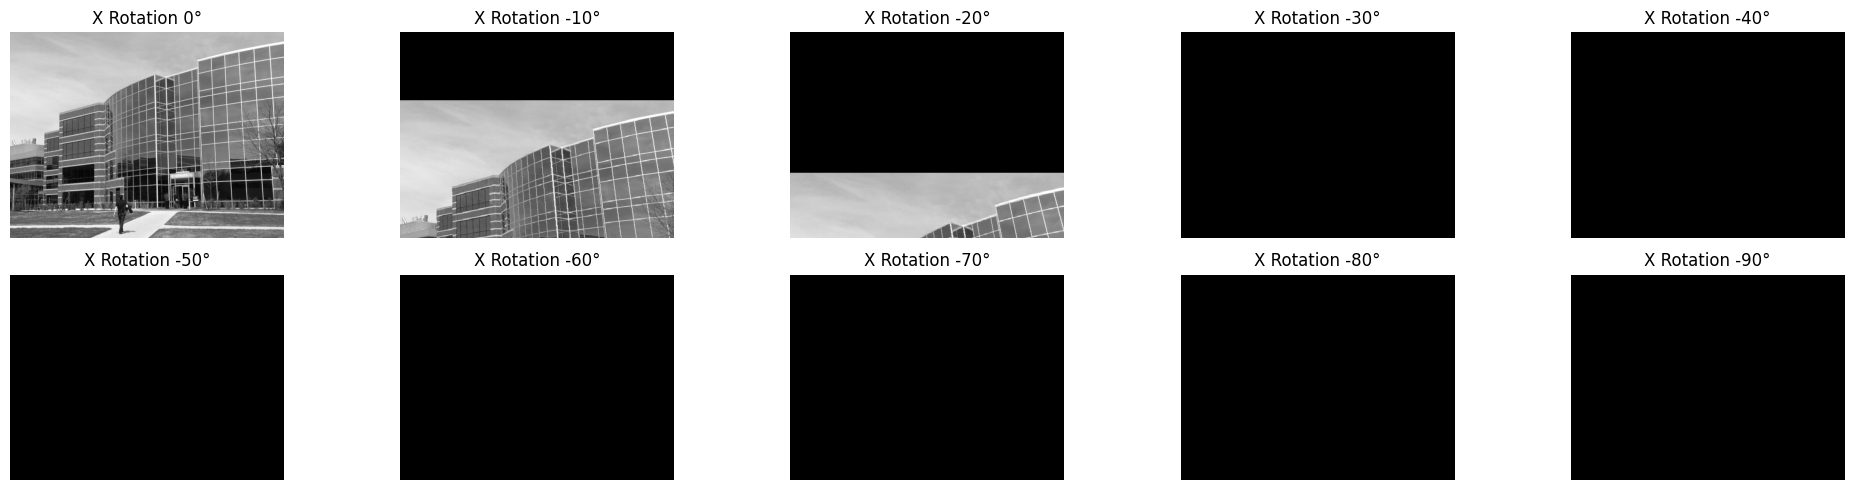

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(20, 5))
axes = axes.ravel()

for idx, i in enumerate(range(0, -100, -10)):
    img_new = prespective_map(rotate_axis(i, 'x'), img.shape)
    axes[idx].imshow(img_new, cmap='gray')
    axes[idx].set_title(f'X Rotation {i}°')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

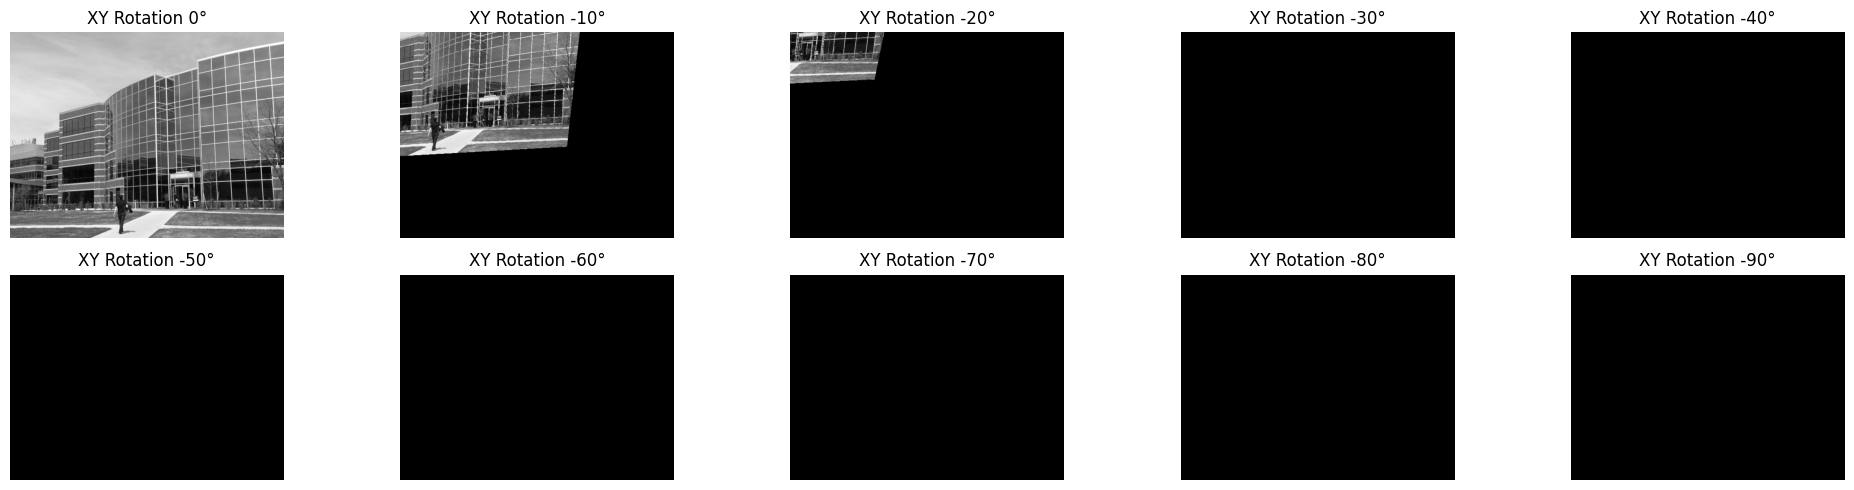

In [10]:
def rotate_xy(deg):
    """
    Rotates a given shape by a specified degree around the x and y axes.

    Parameters:
    deg (float): The degree by which to rotate the shape.
    shape (numpy.ndarray): The shape to be rotated, represented as a numpy array.

    Returns:
    numpy.ndarray: the inverted transformation matrix
    """
    T_x = rotate_axis(deg, 'x')
    T_y = rotate_axis(deg, 'y')
    T = T_y @ T_x
    return np.linalg.inv(T)

fig, axes = plt.subplots(2, 5, figsize=(20, 5))
axes = axes.ravel()

for idx, i in enumerate(range(0, -100, -10)):
    img_new = prespective_map(rotate_xy(i), img.shape)
    axes[idx].imshow(img_new, cmap='gray')
    axes[idx].set_title(f'XY Rotation {i}°')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## Extra credit

Some extra credit if you complete the following task. I will give you extra marks to compesnate for any failings in the other tasks in this e-tivity (if any).

<font color='blue'>
    
##### Task:
    
This doesn't look quite right. The reason is that we expect it to "rotate" about the centre of the image. But in this case, the origin is the top left corner, so this is the point it "rotates" about.
Let's fix this, by adding the first translation to the image centre, then apply the rotation, then translate back for display. This is similar to the previous one where we rotated about the centre, and is really just a modification of that task.
Note, however, that because we are dealing with normalised image coordinates, we have to normalise the image centre too.

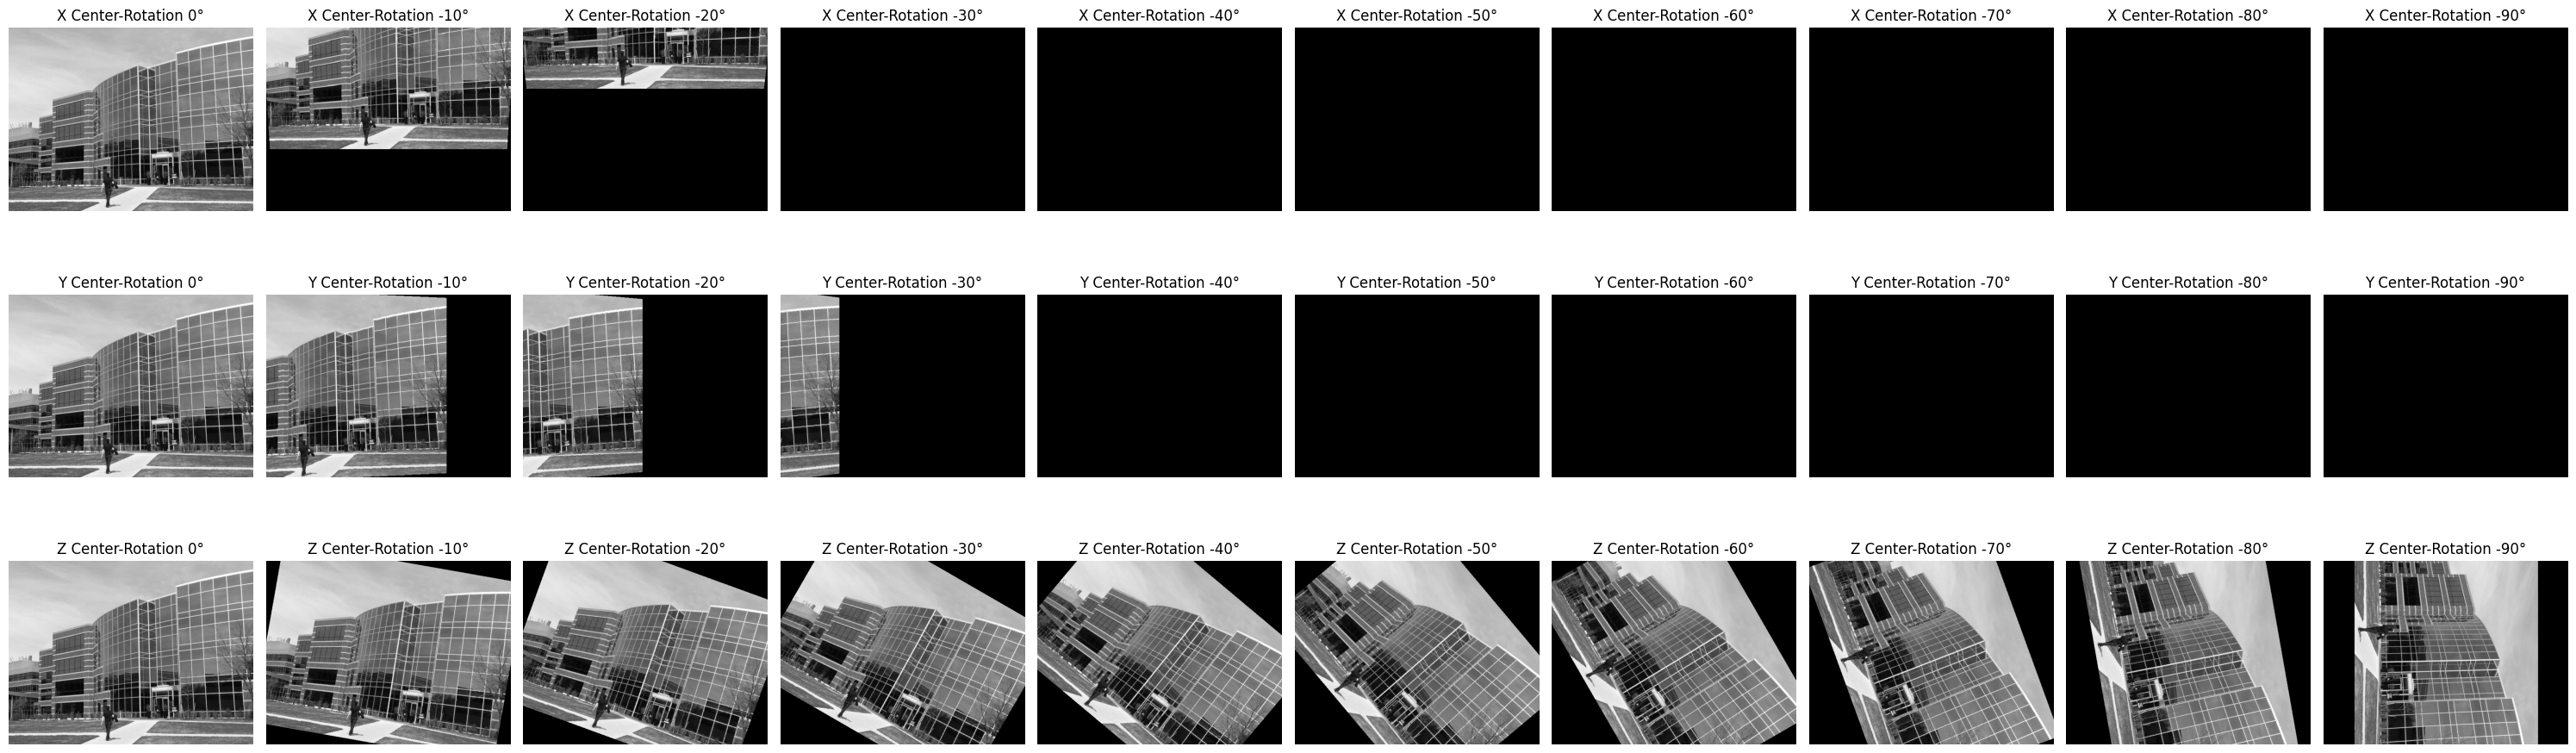

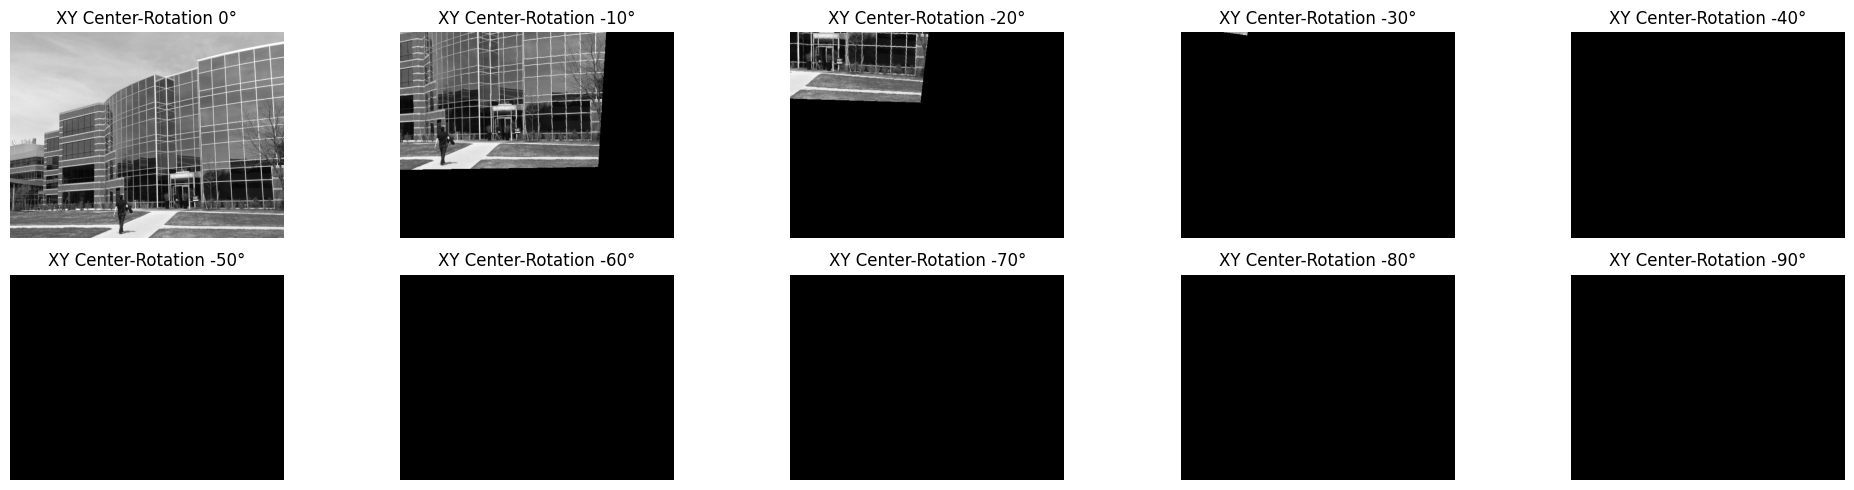

In [11]:
def rotate_xy_about_center(deg, shape):
    """
    Rotates a given shape by a specified degree around the x and y axes.

    Parameters:
    deg (float): The degree by which to rotate the shape.
    shape (numpy.ndarray): the x,y, translation

    Returns:
    numpy.ndarray: the inverted transformation matrix
    """
    T_translate = translate(-shape[0], -shape[1])
    T_translate_back = translate(shape[0], shape[1])
    T_x = rotate_axis(deg, 'x')
    T_y = rotate_axis(deg, 'y')
    T = T_translate_back @ T_y @ T_x @ T_translate
    return np.linalg.inv(T)

def rotate_about_center(deg, shape, axis):
    """
    Rotates a given shape by a specified degree around the specified axis at the center.

    Parameters:
    deg (float): The degree by which to rotate the shape.
    shape (tuple): The shape of the image as a tuple (height, width).
    axis (str): The axis around which to rotate the shape ('x', 'y').

    Returns:
    numpy.ndarray: the inverted transformation matrix
    """
    T_translate = translate(-shape[0], -shape[1])
    T_translate_back = translate(shape[0], shape[1])
    T_axis = rotate_axis(deg, axis)
    T = T_translate_back @ T_axis @ T_translate
    return np.linalg.inv(T)

# plotting code (inspired by other students)

fig, axes = plt.subplots(3, 10, figsize=(30, 10))
axes = axes.ravel()
shape = (img.shape[1]//2 / FOCAL_LENGTH, img.shape[0]//2 / FOCAL_LENGTH)
axes_labels = ['X', 'Y', 'Z']

for j, axis in enumerate(['x', 'y', 'z']):
    for idx, i in enumerate(range(0, -100, -10)):
        img_new = prespective_map(rotate_about_center(i, shape, axis), img.shape)
        axes[j*10 + idx].imshow(img_new, cmap='gray')
        axes[j*10 + idx].set_title(f'{axes_labels[j]} Center-Rotation {i}°')
        axes[j*10 + idx].axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(20, 5))
axes = axes.ravel()
shape = (img.shape[1]//2 / FOCAL_LENGTH, img.shape[0]//2 / FOCAL_LENGTH)
for idx, i in enumerate(range(0, -100, -10)):
    img_new = prespective_map(rotate_xy_about_center(i, shape), img.shape)
    axes[idx].imshow(img_new, cmap='gray')
    axes[idx].set_title(f'XY Center-Rotation {i}°')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

